In [1]:
# import
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [85]:
# file_path = '../data/processed/Customer_Churn_Dataset_0_impute_label.csv'
# file_path = '../data/processed/Customer_Churn_Dataset_knn_label.csv'
# file_path = '../data/processed/Customer_Churn_Dataset_simple_frequent_label.csv'
file_path = '../data/processed/Customer_Churn_Dataset_simple_median_label.csv'

df = pd.read_csv(file_path)

In [ ]:
# # missing flag
# df["TotalCharges_missing_flag"] = 0
# # 원래 결측치였던 0을 다시 구분
# mask_missing = (df["TotalCharges"] == 0) & (df["tenure"] > 0)
# df.loc[mask_missing, "TotalCharges_missing_flag"] = 1

# df["TotalCharges_imputed"] = df["TotalCharges"]
# df.loc[mask_missing, "TotalCharges_imputed"] = \
#     df.loc[mask_missing, "tenure"] * df.loc[mask_missing, "MonthlyCharges"]

# df = df.drop(columns=["TotalCharges"])

In [86]:
drop_cols = ['Unnamed: 0']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

target = 'Churn'
X = df.drop(columns=[target])
y = df[target]

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=0
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2,
    stratify=y_train,   # stratify=output(y값, target, label) 지정.
    random_state=0)

model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    min_child_samples=20,
    is_unbalance=True,
    random_state= 0,
    force_row_wise=True
)
model.fit(X_train, y_train)

# 추론
pred_train_lgbm = model.predict(X_train)
pred_val_lgbm = model.predict(X_val)
pred_test_lgbm = model.predict(X_test)

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print("---------------train set Classification Report---------------")
print(classification_report(y_train, pred_train_lgbm))

print("---------------train set Classification Report---------------")
print(classification_report(y_val, pred_val_lgbm))

print("---------------test set Classification Report---------------")
print(classification_report(y_test, pred_test_lgbm))

---------------train set Classification Report---------------
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      3104
           1       0.84      1.00      0.91      1121

    accuracy                           0.95      4225
   macro avg       0.92      0.96      0.94      4225
weighted avg       0.96      0.95      0.95      4225

---------------train set Classification Report---------------
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       776
           1       0.67      0.85      0.75       281

    accuracy                           0.85      1057
   macro avg       0.80      0.85      0.82      1057
weighted avg       0.87      0.85      0.85      1057

---------------test set Classification Report---------------
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1294
           1       0.66      0.82      0.73       46

In [88]:
model.feature_importances_

array([ 237,  113,  198,  107, 1307,   40,  156,   74,  167,  182,  118,
        136,   71,  124,  212,  172,  353, 2305, 2061,  211,  656],
      dtype=int32)

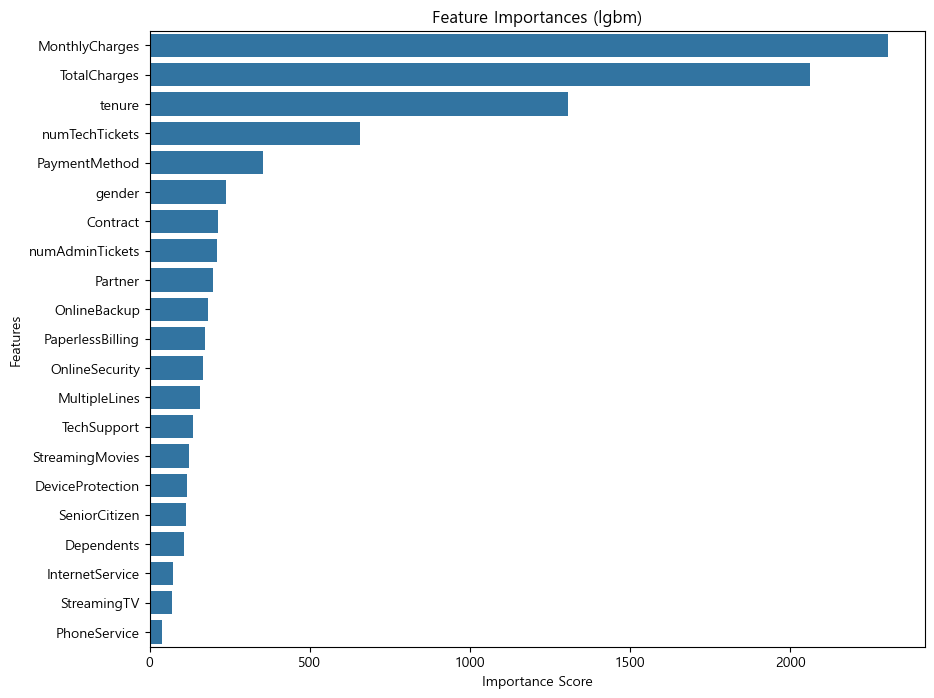

In [89]:
fi = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

importances = model.feature_importances_
feature_names = X_train.columns

# 보기 좋게 정렬하기 위해 Series로 변환
ft_series = pd.Series(importances, index=feature_names)
ft_series = ft_series.sort_values(ascending=False)  # 내림차순 정렬

# 2. 시각화 그리기
plt.figure(figsize=(10, 8))  # 그림 사이즈 조절 (가로, 세로)
plt.title("Feature Importances (lgbm)")

# seaborn을 이용해 가로 막대 그래프 그리기
sns.barplot(x=ft_series, y=ft_series.index)

# 라벨 달기
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [90]:
# Permutation Importance check

from sklearn.inspection import permutation_importance

perm = permutation_importance(
    model,
    X_test,
    y_test,
    scoring='f1',   # 꼭 f1 또는 recall 중심
    n_repeats=10,
    random_state=42
)

importances = perm.importances_mean
for col, imp in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{col}: {imp}")

numTechTickets: 0.17405895918572512
tenure: 0.13889662057065336
Contract: 0.0746511484259805
TotalCharges: 0.04337026467189072
MonthlyCharges: 0.0412969368894298
OnlineSecurity: 0.025065505983254143
InternetService: 0.01582468178170523
MultipleLines: 0.0063047302255478275
Dependents: 0.003516760531143459
DeviceProtection: 0.003286237053284247
Partner: 0.003193154361166717
TechSupport: 0.003191652954854629
PhoneService: 0.0018574728347560353
SeniorCitizen: 0.0018337496665742803
StreamingMovies: 0.0009154681699547363
numAdminTickets: 0.0009024268722063744
gender: 0.0005803414476560409
PaperlessBilling: 0.00043362320278588217
PaymentMethod: 0.0003805950350651677
OnlineBackup: -0.0005120733589473958
StreamingTV: -0.0010545980595651594


In [91]:
high_importance_feature = ['numTechTickets', 'tenure', 'Contract', 'MonthlyCharges', 'TotalCharges']
middle_importance_featrue = ['OnlineSecurity', 'InternetService', 'PaymentMethod',
 'TechSupport', 'MultipleLines']
low_importance_feature = ['SeniorCitizen', 'StreamingTV', 'PaperlessBilling', 'PhoneService',
 'Partner', 'Dependents', 'OnlineBackup', 'numAdminTickets',
 'DeviceProtection', 'gender', 'StreamingMovies']

In [ ]:
# high_importance_feature.remove('TotalCharges')
# high_importance_feature.append('TotalCharges_imputed')
# low_importance_feature.append('TotalCharges_missing_flag')

In [92]:
# low_importance_feature 제거 후 비교
# 0 impute: 기존 acc = 0.83 , f1_score = 0.72, recall = 0.82
# 0 impute: low 제외 후 acc = 0.83, f1_score = 0.72, recall = 0.84
# knn 83 72 82
df_except_low = df.drop(columns= low_importance_feature)

target = 'Churn'
X = df_except_low.drop(columns=[target])
y = df_except_low[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=0
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2,
    stratify=y_train,   # stratify=output(y값, target, label) 지정.
    random_state=0)

model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    min_child_samples=20,
    is_unbalance=True,
    random_state= 0,
    force_row_wise=True
)
model.fit(X_train, y_train)

# 추론
pred_val_lgbm = model.predict(X_val)
pred_test_lgbm = model.predict(X_test)

print("---------------vakl set Classification Report---------------")
print(classification_report(y_val, pred_val_lgbm))

print("---------------test set Classification Report---------------")
print(classification_report(y_test, pred_test_lgbm))

---------------vakl set Classification Report---------------
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       776
           1       0.65      0.87      0.75       281

    accuracy                           0.84      1057
   macro avg       0.80      0.85      0.82      1057
weighted avg       0.87      0.84      0.85      1057

---------------test set Classification Report---------------
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1294
           1       0.64      0.82      0.72       467

    accuracy                           0.83      1761
   macro avg       0.78      0.83      0.80      1761
weighted avg       0.85      0.83      0.83      1761



In [93]:
# low_importance_feature 제거 후 비교
# 0 impute: 기존 acc = 0.83 , f1_score = 0.72, recall = 0.82
# 0 impute: low 제외 후 acc = 0.83, f1_score = 0.72, recall = 0.84
# 0 impute: middle 제외 후 acc = 0.82, f1_score = 0.72, recall = 0.84
# knn 83 72 82
# knn 83 72 83
df_middle_low = df_except_low.drop(columns= middle_importance_featrue)

target = 'Churn'
X = df_middle_low.drop(columns=[target])
y = df_middle_low[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=0
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2,
    stratify=y_train,   # stratify=output(y값, target, label) 지정.
    random_state=0)

model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    min_child_samples=20,
    is_unbalance=True,
    random_state= 0,
    force_row_wise=True
)
model.fit(X_train, y_train)

# 추론
pred_val_lgbm = model.predict(X_val)
pred_test_lgbm = model.predict(X_test)

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print("---------------train set Classification Report---------------")
print(classification_report(y_val, pred_val_lgbm))

print("---------------test set Classification Report---------------")
print(classification_report(y_test, pred_test_lgbm))

---------------train set Classification Report---------------
              precision    recall  f1-score   support

           0       0.94      0.80      0.87       776
           1       0.61      0.86      0.71       281

    accuracy                           0.82      1057
   macro avg       0.78      0.83      0.79      1057
weighted avg       0.85      0.82      0.83      1057

---------------test set Classification Report---------------
              precision    recall  f1-score   support

           0       0.94      0.82      0.87      1294
           1       0.62      0.85      0.72       467

    accuracy                           0.82      1761
   macro avg       0.78      0.83      0.80      1761
weighted avg       0.85      0.82      0.83      1761



In [94]:
# middle_importance_feature 제거 후가 더 좋다고 판단했으나, Optuna를 위해 좀 더 feature수가 필요.
# low_importance_feature 제거 상태에서 진행

import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score
import optuna
import numpy as np
import tqdm

In [95]:
high_importance_feature = ['numTechTickets', 'tenure', 'Contract', 'MonthlyCharges', 'TotalCharges']
middle_importance_featrue = ['OnlineSecurity', 'InternetService', 'PaymentMethod',
 'TechSupport', 'MultipleLines']
low_importance_feature = ['SeniorCitizen', 'StreamingTV', 'PaperlessBilling', 'PhoneService',
 'Partner', 'Dependents', 'OnlineBackup', 'numAdminTickets',
 'DeviceProtection', 'gender', 'StreamingMovies']

In [ ]:
# high_importance_feature.remove('TotalCharges')
# high_importance_feature.append('TotalCharges_imputed')
# low_importance_feature.append('TotalCharges_missing_flag')

In [96]:
# file_path = '../data/processed/Customer_Churn_Dataset_0_impute_label.csv'
df = pd.read_csv(file_path)

drop_cols = ['Unnamed: 0']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,0,0,1,0,1,0,2,1,0,1,...,0,0,0,1,2,29.85,29.85,0,0,0
1,1,0,0,0,34,1,0,1,1,0,...,0,0,1,0,3,56.95,1889.50,0,0,0
2,1,0,0,0,2,1,0,1,1,1,...,0,0,0,1,3,53.85,108.15,0,0,1
3,1,0,0,0,45,0,2,1,1,0,...,0,0,1,0,0,42.30,1840.75,0,3,0
4,0,0,0,0,2,1,0,2,0,0,...,0,0,0,1,2,70.70,151.65,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,1,1,0,...,1,1,1,1,3,84.80,1990.50,0,0,0
7039,0,0,1,1,72,1,1,2,0,1,...,1,1,1,1,1,103.20,7362.90,0,5,0
7040,0,0,1,1,11,0,2,1,1,0,...,0,0,0,1,2,29.60,346.45,0,0,0
7041,1,1,1,0,4,1,1,2,0,0,...,0,0,0,1,3,74.40,306.60,0,0,1


In [97]:
df = df.drop(columns=low_importance_feature)

target = 'Churn'
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=0
)

In [98]:
# Optuna 정의
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "boosting_type": "gbdt",
        "is_unbalance": True,
        "force_row_wise": True,
        "random_state": 0,
        'min_split_gain': 0.0,

        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 40, 100),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 25),

        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 1.0),

        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 0.2),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 0.2),

         "verbose": -1 # info 메시지 가리기
    }

    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    return f1_score(y_test, preds)

# Optuna Study 생성
study = optuna.create_study(
    direction="maximize",
    study_name="lgbm_opt"
)

# 튜닝 시작
study.optimize(objective, n_trials=50)

[I 2025-11-25 15:03:31,982] A new study created in memory with name: lgbm_opt
[I 2025-11-25 15:03:32,771] Trial 0 finished with value: 0.7139917695473251 and parameters: {'n_estimators': 572, 'learning_rate': 0.056471459606799224, 'num_leaves': 54, 'min_child_samples': 10, 'subsample': 0.8508406402008055, 'colsample_bytree': 0.949410543509484, 'reg_alpha': 0.1148369271908403, 'reg_lambda': 0.04857212100664168}. Best is trial 0 with value: 0.7139917695473251.
[I 2025-11-25 15:03:33,456] Trial 1 finished with value: 0.717948717948718 and parameters: {'n_estimators': 360, 'learning_rate': 0.06982388776147494, 'num_leaves': 82, 'min_child_samples': 17, 'subsample': 0.8447975842013334, 'colsample_bytree': 0.9451359558257171, 'reg_alpha': 0.08283797532545126, 'reg_lambda': 0.13369017335358988}. Best is trial 1 with value: 0.717948717948718.
[I 2025-11-25 15:03:33,673] Trial 2 finished with value: 0.7318489835430784 and parameters: {'n_estimators': 201, 'learning_rate': 0.09037996187593975, '

In [99]:
# Best Params 출력
print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

Best Params: {'n_estimators': 406, 'learning_rate': 0.010371102450224719, 'num_leaves': 100, 'min_child_samples': 25, 'subsample': 0.9903185258714189, 'colsample_bytree': 0.8076275962990893, 'reg_alpha': 0.19709769389788603, 'reg_lambda': 0.1971322228872522}
Best Score: 0.7453531598513011


In [100]:
# 5. Best Model 재학습
best_model = LGBMClassifier(
    **study.best_params,
    objective="binary",
    is_unbalance=True,
    force_row_wise=True,
    random_state=0
)

best_model.fit(X_train, y_train)

,boosting_type,'gbdt'
,num_leaves,100
,max_depth,-1
,learning_rate,0.010371102450224719
,n_estimators,406
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,25


In [101]:
pred = best_model.predict(X_test)
proba = best_model.predict_proba(X_test)[:, 1]

print("Accuracy :", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred))
print("Recall   :", recall_score(y_test, pred))
print("F1-score :", f1_score(y_test, pred))
print("ROC-AUC  :", roc_auc_score(y_test, proba))

# low 제외 후 acc = 0.84, f1_score = 0.73, recall = 0.84
# optuna 진행 후 acc = 0.83, f1_score = 0.743, recall = 0.88

Accuracy : 0.8444065871663827
Precision: 0.6584564860426929
Recall   : 0.8586723768736617
F1-score : 0.7453531598513011
ROC-AUC  : 0.9235046285110988


In [102]:
def threshold_search(y_true, y_proba):
    thresholds = np.arange(0.01, 1.00, 0.01)
    best_threshold = 0.5
    best_f1 = 0
    
    results = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)

        results.append([t, f1, recall, precision, accuracy])

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    return best_threshold, best_f1, results

y_proba = best_model.predict_proba(X_test)[:, 1]
best_t, best_f1, result_table = threshold_search(y_test, y_proba)

print("Best Threshold:", best_t)
print("Best F1 Score:", best_f1)

Best Threshold: 0.51
Best F1 Score: 0.7457943925233644


c:\documents\Project\SKN21-2nd-4Team\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
# final_threshold = 0.59 # 0impute
# final_threshold = 0.5 # knn
# final_threshold = 0.52 # frequent
final_threshold = 0.51 # median

def predict_with_threshold(model, X, threshold=final_threshold):
    proba = model.predict_proba(X)[:, 1]
    pred = (proba >= threshold).astype(int)
    return pred, proba

final_pred, final_proba = predict_with_threshold(best_model, X_test)

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

print("=== Final Metrics (Threshold Applied) ===")
print("Accuracy:", accuracy_score(y_test, final_pred))
print("Precision:", precision_score(y_test, final_pred))
print("Recall:", recall_score(y_test, final_pred))
print("F1:", f1_score(y_test, final_pred))

=== Final Metrics (Threshold Applied) ===
Accuracy: 0.845542305508234
Precision: 0.6616915422885572
Recall: 0.854389721627409
F1: 0.7457943925233644


In [ ]:
# # 0 impute
# Accuracy: 0.8506530380465644
# Precision: 0.6821428571428572
# Recall: 0.8179871520342612
# F1: 0.7439143135345667

# # knn
# Accuracy: 0.8421351504826803
# Precision: 0.6551724137931034
# Recall: 0.854389721627409
# F1: 0.741635687732342

# frequent
# Accuracy: 0.8449744463373083
# Precision: 0.6638513513513513
# Recall: 0.841541755888651
# F1: 0.7422096317280453

# # median
# Accuracy: 0.845542305508234
# Precision: 0.6616915422885572
# Recall: 0.854389721627409
# F1: 0.7457943925233644


SyntaxError: invalid syntax (3159496815.py, line 1)

In [43]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, final_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1116  178]
 [  85  382]]


In [44]:
import joblib
import os

In [72]:
model_package = {
    "model": best_model,
    "threshold": final_threshold,
    "feature_columns": X_train.columns.tolist()
}

joblib.dump(model_package, "../src/models/ML/model_dir/LGBM_model.pkl")
print("Model + Threshold saved!")


FileNotFoundError: [Errno 2] No such file or directory: '../src/models/ML/model_dir/LGBM_model.pkl'